In [1]:
from matplotlib import pyplot as plt
import os
import itertools

from collections import defaultdict, Counter
from random import Random
from functools import partial

from urllib import request, parse

import numpy as np
import pandas as pd

%matplotlib inline


# The ATIS Dataset

The ATIS DataSet is widely used [TODO add the references] benchmark dataset for intent classification and slot filling models used in dialog systems.

This notebook will:
  
  1. fetch the ATIS DataSet from https://github.com/yvchen/JointSLU 
  2. Explore the the slot and intent label distribution accross the the train/dev/test dataset split
  3. Provide an alternative (balanced) datasplit
  







## Fetching the dataset
The ATIS dataset from [yvchen/JointSLU](https://github.com/yvchen/JointSLU) is provided as train, dev and test split in text format, one sample per line with whitespace separated tokens and IOB tags, followeb by the intent label, i.e.:

    BOS from denver to baltimore EOS O O B-fromloc.city_name O B-toloc.city_name atis_flight
    BOS ground transportation in denver EOS  O O O O B-city_name atis_ground_service

In [2]:
ATIS_BASE_URL = "https://raw.githubusercontent.com/yvchen/JointSLU/master/data/"


def load_atis_dataset(filenames: str | list[str] | tuple[str], base_url=ATIS_BASE_URL) -> dict:
    datasets = {}

    if isinstance(filenames, str):
        fname = [filenames]

    for name in filenames:
        dataset_content = []
        dataset_name = '.'.join(name.split('.')[:2])

        with request.urlopen(parse.urljoin(base_url, name)) as download:

            for line in download.readlines():
                # Decode line
                line = line.decode(download.info().get_content_charset())

                # Extract tokens, etc. for each line of the .iob file
                tokens, si = map(str.split, line.split("\t"))
                slots, intent = si[:-1] + ['O'], si[-1]

                # Break everything if the is any inconsistency in the dataset
                assert len(tokens) == len(slots)

                # Add the data to dataset representation
                dataset_content.append((tokens, slots, intent))

        # Add each dataset to the dictionary
        datasets.update({dataset_name: dataset_content})
        # print(f'{ds_name:>20s}: {len(dataset_content):4d}')
    return datasets


files_to_download = [
    f'{name}.w-intent.iob' for name in ('atis.test', 'atis-2.dev', 'atis-2.train')]
atis = load_atis_dataset(files_to_download)

for key, value in atis.items():
    print(f'{key:>20s}: {len(value):4d}')


           atis.test:  893
          atis-2.dev:  500
        atis-2.train: 4478


## Exploring the data splits

In [3]:
# a single entry looks like this
toks, slots, intent = atis['atis.test'][0]
print(' input:', ' '.join(toks))
print(' slots:', ' '.join(slots))
print('intent:',          intent)


 input: BOS i would like to find a flight from charlotte to las vegas that makes a stop in st. louis EOS
 slots: O O O O O O O O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O O O O O B-stoploc.city_name I-stoploc.city_name O
intent: atis_flight


Lets check if all labels are present in both the train and test (or dev) data splits.

In [4]:
test, dev, train = map(atis.get, ['atis.test', 'atis-2.dev', 'atis-2.train'])


def subdict(counter: Counter, keys: set) -> dict:
    return {key: counter[key] for key in keys}


def atis_label_counts(datasets: list | tuple | set) -> tuple:
    tokens, slots, intents = zip(*datasets)

    return (Counter(list(itertools.chain.from_iterable(tokens))),  # token_labs
            Counter(list(itertools.chain.from_iterable(slots))),  # slot_labs
            Counter(intents))  # intent_labs


def check_atis_split(train, dev, test) -> None:
    (_, ts, ti), (_, ds, di), (_, es, ei) = map(atis_label_counts,
                                                [train, dev, test])

    lens = list(map(len, (train, dev, test)))
    sample_count = np.sum(lens)

    print(f"   sample count: {sample_count:5d} splitted into:")
    for dslen, dsname in zip(lens, ['train', 'dev', 'test']):
        print(f"          {dsname:>5s}: {dslen:5d} ({dslen/sample_count:.3f})")

    unique_entries = {(tuple(toks), tuple(slots), intent)
                      for toks, slots, intent in (train + dev + test)}

    print(f"duplicate count: {sample_count - len(unique_entries):5d}")

    # map slot/intent labels to usage frequency
    token_labs, slot_labs, intent_labs = atis_label_counts(train + dev + test)
    sfreqs, ifreqs = map(partial(partial, subdict), [slot_labs, intent_labs])
    # print(sfreqs, ifreqs)

    print("   intent count:", len(intent_labs))
    print("     slot count:", len(slot_labs))
    print("    token count:", len(token_labs))

    print("missing data for slot/intent labels:")
    ts, ti, ds, di, es, ei = map(lambda s: set(s.keys()), [
                                 ts, ti, ds, di, es, ei])
    for dsname, mints, mslots in [("train",
                                   ifreqs(di.union(ei).difference(ti)),
                                   sfreqs(ds.union(es).difference(ts))),
                                  ("dev",
                                   ifreqs(ti.difference(di)),
                                   sfreqs(ts.difference(ds))),
                                  ("test",
                                   ifreqs(ti.difference(ei)),
                                   sfreqs(ts.difference(es)))]:
        print(f"  no {dsname:>5s} data for {len(mints):2d} intents: {mints}")
        print(f"  no {dsname:>5s} data for {len(mslots):2d}   slots: {mslots}")


check_atis_split(train, dev, test)


   sample count:  5871 splitted into:
          train:  4478 (0.763)
            dev:   500 (0.085)
           test:   893 (0.152)
duplicate count:   397
   intent count: 26
     slot count: 127
    token count: 952
missing data for slot/intent labels:
  no train data for  5 intents: {'atis_flight#atis_airline': 1, 'atis_airfare#atis_flight': 1, 'atis_flight_no#atis_airline': 1, 'atis_day_name': 2, 'atis_airfare#atis_flight_time': 1}
  no train data for  7   slots: {'I-state_name': 1, 'B-flight': 1, 'I-flight_number': 1, 'B-stoploc.airport_code': 1, 'B-compartment': 1, 'B-booking_class': 1, 'I-return_date.day_number': 1}
  no   dev data for  6 intents: {'atis_ground_service#atis_ground_fare': 1, 'atis_cheapest': 1, 'atis_meal': 12, 'atis_flight_no': 20, 'atis_aircraft#atis_flight#atis_flight_no': 1, 'atis_airline#atis_flight_no': 2}
  no   dev data for 25   slots: {'I-meal_code': 4, 'I-depart_time.time_relative': 3, 'I-arrive_time.time_relative': 6, 'B-return_date.day_name': 3, 'I-arri

So from above, we see, there are 5 intent and 7 slot labels not present at all in the train dataset. And quite simillary up to 20% of the labels are not present in the dev or test dataset. There are also 397 duplicated entries.

As a visualization:

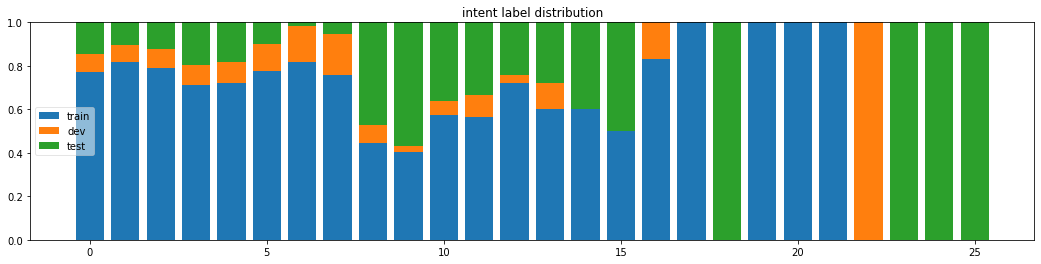

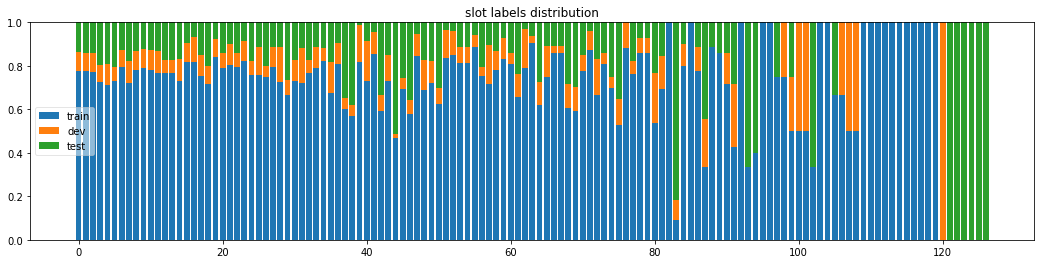

In [5]:
def visualize_atis_split(train, dev, test) -> None:
    (_, ts, ti), (_, ds, di), (_, es, ei) = map(atis_label_counts,
                                                [train, dev, test])
    _, alls, alli = atis_label_counts(train+dev+test)

    tsc, dsc, esc, asc = (np.array([d[slot] for slot, _ in alls.most_common()])
                          for d in [ts, ds, es, alls])
    tic, dic, eic, aic = (np.array([d[intent] for intent, _ in alli.most_common()])
                          for d in [ti, di, ei, alli])

    plt.figure(figsize=(18, 4))
    plt.title('intent label distribution')
    plt.bar(x=np.arange(len(tic)), height=tic /
            aic, label='train')
    plt.bar(x=np.arange(len(dic)), height=dic /
            aic, bottom=tic/aic, label='dev')
    plt.bar(x=np.arange(len(eic)), height=eic/aic,
            bottom=(tic+dic)/aic, label='test')
    plt.legend(loc='center left', fancybox=True, framealpha=0.5)

    plt.figure(figsize=(18, 4))
    plt.title('slot labels distribution')
    plt.bar(x=np.arange(len(tsc)), height=tsc /
            asc, label='train')
    plt.bar(x=np.arange(len(dsc)), height=dsc /
            asc, bottom=tsc/asc, label='dev')
    plt.bar(x=np.arange(len(esc)), height=esc/asc,
            bottom=(tsc+dsc)/asc, label='test')
    plt.legend(loc='center left', fancybox=True, framealpha=0.5)


visualize_atis_split(train, dev, test)


## (Re)Splitting the ATIS dataset

Before we split, we should remove any duplicates and all samples containing labels occurring less than 3 times (we actually remove samples with labels occurring less than 4 times, after inspecting the output of `check_atis_split()` for a dataset cleaned with the "less than 3 times" label rule).

In [6]:
test, dev, train = map(atis.get, ['atis.test', 'atis-2.dev', 'atis-2.train'])
atis_all = train + dev + test

print("original ATIS    data count:", len(atis_all))

# keep unique entries only
cleands = set([(tuple(toks), tuple(slots), intent)
              for toks, slots, intent in atis_all])
print("   after duplicates removal:", len(cleands))

# count label frequencies
_, slot_labs, intent_labs = atis_label_counts(cleands)

# filter labels occuring only once
clean_slots = dict(filter(lambda t: t[1] > 3, slot_labs.most_common()))
clean_intents = dict(filter(lambda t: t[1] > 3, intent_labs.most_common()))

# remove the corresponding data samples
cleands = filter(lambda t: set(t[1]).issubset(clean_slots), cleands)
cleands = filter(lambda t: t[2] in clean_intents, cleands)

cleands = list(filter(lambda t: set(t[1]).issubset(
    slot_labs) and t[2] in intent_labs, cleands))
print("       after label cleaning:", len(cleands))

# convert back from tuples to lists
atis_clean = [(list(tokens), list(slots), intent)
              for tokens, slots, intent in sorted(cleands)]


original ATIS    data count: 5871
   after duplicates removal: 5474
       after label cleaning: 5432


Now let's split the dataset by starting with the most rare labels, and hope every split receive an example for each intent/solt label.

In [7]:
def split_atis(ads, split=[0.8, 0.1, 0.1], random_state=None):
    """ Splits the ATIS dataset by starting with the least common labels."""
    split = np.array(split)
    assert split.sum() == 1

    random = None if random_state is None else Random(random_state)

    res = [[] for _ in split]
    used = set()             # used samples
    s2e = defaultdict(set)   # slot to sample
    i2e = defaultdict(set)   # intent to sample
    for ndx, (_, slots, intent) in enumerate(ads):  # build label to sample maps
        i2e[intent].add(ndx)
        for slot in set(slots):
            s2e[slot].add(ndx)

    # sort according to usage
    s2f = Counter({slot: len(ndxs)
                  for slot, ndxs in s2e.items()}).most_common()
    i2f = Counter({intent: len(ndxs)
                  for intent, ndxs in i2e.items()}).most_common()

    while True:
        # select the least common intent or slot label
        if len(i2f) < 1 and len(s2f) < 1:            # both empty
            break
        elif len(i2f) > 0 and len(s2f) > 0:          # both non empty
            use_intent = i2f[-1][1] < s2f[-1][1]
        else:
            use_intent = len(i2f) > 0

        # get the samples of least common label
        if use_intent:
            intent, _ = i2f.pop()
            ndxs = i2e.pop(intent)
        else:
            slot, _ = s2f.pop()
            ndxs = s2e.pop(slot)

        # shuffle the samples of the selected label
        ndxs = list(ndxs)
        if random is not None:
            random.shuffle(ndxs)

        splits = [[] for _ in split]
        # put each sample in a split maintaining the split ratios
        for ndx in ndxs:
            lens = np.array([len(sp) for sp in splits])
            # fill the split with the highest frequency (reverse ratio) offset
            sndx = np.argmax(1/(lens/(lens.sum()+1e-12)+1e-12) - 1/split)
            if ndx not in used:
                used.add(ndx)
                splits[sndx].append(ndx)

        # add the splitted label samples to the result split
        for ndx, ndxs in enumerate(splits):
            res[ndx].extend(ndxs)

    return res


In [14]:
train, test, dev = split_atis(atis_clean, [0.8, 0.1, 0.1], random_state=7411)
train, test, dev = map(lambda ndxs: np.array(atis_clean, dtype=object)[ndxs].tolist(),
                       [train, test, dev])


In [9]:
check_atis_split(train,dev,test)

   sample count:  5432 splitted into:
          train:  4274 (0.787)
            dev:   572 (0.105)
           test:   586 (0.108)
duplicate count:     0
   intent count: 17
     slot count: 101
    token count: 945
missing data for slot/intent labels:
  no train data for  0 intents: {}
  no train data for  0   slots: {}
  no   dev data for  0 intents: {}
  no   dev data for  0   slots: {}
  no  test data for  0 intents: {}
  no  test data for  0   slots: {}


This already looks better (and we haven't loosed too many data samples) - now let's visualize:

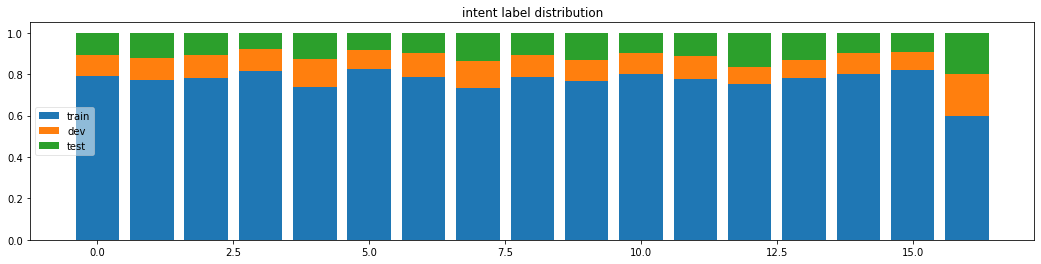

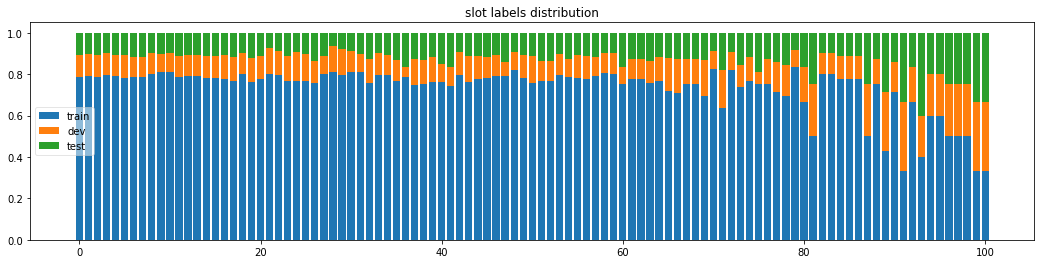

In [10]:
visualize_atis_split(train,dev,test)

## Dump the ATIS data split

Now lets dump the ATIS datasets in a CSV format.

In [11]:
# lets dump the split in a CSV file per dataset
def store_atis_csv(ds, dsname):
    fname = "atis.{}.csv".format(dsname)
    with open(fname, 'wt', encoding='UTF-8') as f:
        f.write("id,tokens,slots,intent\n") # csv header
        for ndx, (toks, slots, intent) in enumerate(ds, 1):
            uid = "{}-{:05d}".format(dsname, ndx)
            line = "{},{},{},{}\n".format(uid, 
                                         " ".join(toks), 
                                         " ".join(slots),
                                         intent)
            f.write(line)
    print("Done writting {} to {}".format(dsname,fname))
    
store_atis_csv(train, "train")
store_atis_csv(dev,   "dev")
store_atis_csv(test,  "test")

Done writting train to atis.train.csv
Done writting dev to atis.dev.csv
Done writting test to atis.test.csv


In [12]:
pd.read_csv('atis.train.csv').head()

,id,tokens,slots,intent
0,train-00001,BOS what is the cost of a round trip flight fr...,O O O O O O O B-round_trip I-round_trip O O B-...,atis_airfare
1,train-00002,BOS now i need a flight leaving fort worth and...,O O O O O O O B-fromloc.city_name I-fromloc.ci...,atis_flight
2,train-00003,BOS i need to fly from kansas city to chicago ...,O O O O O O B-fromloc.city_name I-fromloc.city...,atis_flight
3,train-00004,BOS what is the meaning of meal code s EOS,O O O O O O B-meal_code I-meal_code I-meal_code O,atis_abbreviation
4,train-00005,BOS show me all flights from denver to pittsbu...,O O O O O O B-fromloc.city_name O B-toloc.city...,atis_flight
